# Stage 2: Model Training & Optimization

**Objectives**:
- Design and train a CNN or Vision Transformer using fastai
- Optimize hyperparameters (learning rate, batch size, epochs)
- Monitor training progress and prevent overfitting
- Export the best-performing model

**Output**: `model.pkl` - trained model ready for evaluation

## 1. Import Libraries and Setup

In [1]:
# Add parent directory to path for imports
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

import fastai
from fastai.vision.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import set_seed as set_all_seeds

# Set comprehensive random seed for reproducibility
SEED = 42
set_all_seeds(SEED)  # Set seeds for Python, NumPy, PyTorch
set_seed(SEED, reproducible=True)  # fastai's set_seed for additional reproducibility

# Check device
print(f"PyTorch version: {torch.__version__}")
print(f"fastai version: {fastai.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"Device: {default_device()}")

✓ Random seed set to 42 for reproducibility
PyTorch version: 2.9.1
fastai version: 2.8.5
CUDA available: False
MPS available: True
Device: mps


## 2. Configuration

In [48]:
# Hyperparameters
BATCH_SIZE = 32
IMG_SIZE = 224
ARCHITECTURE = resnet18  # Options: resnet18, resnet34, resnet50, efficientnet_b0
EPOCHS_FROZEN = 20
EPOCHS_UNFROZEN = 20

print("Configuration:")
print(f"  Architecture: {ARCHITECTURE.__name__}")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs (frozen): {EPOCHS_FROZEN}")
print(f"  Epochs (unfrozen): {EPOCHS_UNFROZEN}")
print(f"  Random seed: {SEED}")

Configuration:
  Architecture: resnet18
  Image size: 224x224
  Batch size: 32
  Epochs (frozen): 20
  Epochs (unfrozen): 20
  Random seed: 42


## 3. Load Data Split

In [49]:
# Load saved split
split_df = pd.read_csv('../outputs/data_split.csv')

print(f"Total images: {len(split_df)}")
print(f"\nSplit distribution:")
print(split_df['split'].value_counts().sort_index())
print(f"\nClass distribution:")
print(split_df['label'].value_counts().sort_index())

# Verify data integrity
assert len(split_df) == 2500, "Expected 2500 total images"
assert set(split_df['split'].unique()) == {'train', 'val', 'test'}, "Expected train/val/test splits"
assert len(split_df['label'].unique()) == 5, "Expected 5 classes"

print("\n✓ Data integrity verified")
split_df.head()

Total images: 2500

Split distribution:
split
test      375
train    1750
val       375
Name: count, dtype: int64

Class distribution:
label
basophil      500
eosinophil    500
lymphocyte    500
monocyte      500
neutrophil    500
Name: count, dtype: int64

✓ Data integrity verified


,filepath,filename,label,split
0,Dataset and Notebook-20251115/dataset_leukocytes/neutrophil/BNE_30848.jpg,BNE_30848.jpg,neutrophil,train
1,Dataset and Notebook-20251115/dataset_leukocytes/monocyte/MO_87762.jpg,MO_87762.jpg,monocyte,train
2,Dataset and Notebook-20251115/dataset_leukocytes/eosinophil/EO_487696.jpg,EO_487696.jpg,eosinophil,train
3,Dataset and Notebook-20251115/dataset_leukocytes/monocyte/MO_311939.jpg,MO_311939.jpg,monocyte,train
4,Dataset and Notebook-20251115/dataset_leukocytes/eosinophil/EO_48767.jpg,EO_48767.jpg,eosinophil,train


## 4. Create DataLoaders

In [50]:
# Filter for train and validation only
train_val_df = split_df[split_df['split'].isin(['train', 'val'])].copy()

# Fix file paths - prepend '../' since we're running from notebooks/ directory
train_val_df['filepath'] = '../' + train_val_df['filepath']

# Verify a few paths exist
print("Verifying file paths...")
for i in range(min(3, len(train_val_df))):
    path = Path(train_val_df.iloc[i]['filepath'])
    status = "✓" if path.exists() else "✗"
    print(f"  {status} {path}")

train_val_df = train_val_df.reset_index(drop=True)

print(f"\nTrain+Val samples: {len(train_val_df)}")
print(f"\nSplit breakdown:")
print(train_val_df['split'].value_counts().sort_index())

# Create custom splitter based on saved split
def splitter(df):
    """
    Custom splitter that uses the saved train/val split
    Returns: (train_indices, valid_indices)
    """
    train_idx = df.index[df['split'] == 'train'].tolist()
    valid_idx = df.index[df['split'] == 'val'].tolist()
    return train_idx, valid_idx

# Verify splitter
train_idx, valid_idx = splitter(train_val_df)
print(f"\nSplitter output:")
print(f"  Training indices: {len(train_idx)} samples")
print(f"  Validation indices: {len(valid_idx)} samples")

# Verify no overlap
assert len(set(train_idx) & set(valid_idx)) == 0, "Train and validation sets overlap!"
print("✓ No overlap between train and validation sets")

Verifying file paths...
  ✓ ../Dataset and Notebook-20251115/dataset_leukocytes/neutrophil/BNE_30848.jpg
  ✓ ../Dataset and Notebook-20251115/dataset_leukocytes/monocyte/MO_87762.jpg
  ✓ ../Dataset and Notebook-20251115/dataset_leukocytes/eosinophil/EO_487696.jpg

Train+Val samples: 2125

Split breakdown:
split
train    1750
val       375
Name: count, dtype: int64

Splitter output:
  Training indices: 1750 samples
  Validation indices: 375 samples
✓ No overlap between train and validation sets


In [51]:
# Define DataBlock with augmentations
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('filepath'),
    get_y=ColReader('label'),
    splitter=splitter,
    item_tfms=Resize(IMG_SIZE),
    batch_tfms=aug_transforms(
        size=IMG_SIZE,
        min_scale=0.75,        # Random crop 75-100% of image
        max_rotate=180.0,       # Rotate up to ±15 degrees
        max_lighting=0.5,      # Adjust brightness/contrast
        max_warp=0.2,          # Perspective warp
        p_affine=0.75,         # 75% chance of affine transforms
        p_lighting=0.75        # 75% chance of lighting transforms
    )
)

# Create DataLoaders
dls = dblock.dataloaders(train_val_df, bs=BATCH_SIZE)

print(f"\nDataLoader Summary:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Training batches: {len(dls.train)}")
print(f"  Validation batches: {len(dls.valid)}")
print(f"  Classes: {dls.vocab}")
print(f"  Number of classes: {dls.c}")


DataLoader Summary:
  Batch size: 32
  Image size: 224x224
  Training batches: 54
  Validation batches: 12
  Classes: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
  Number of classes: 5


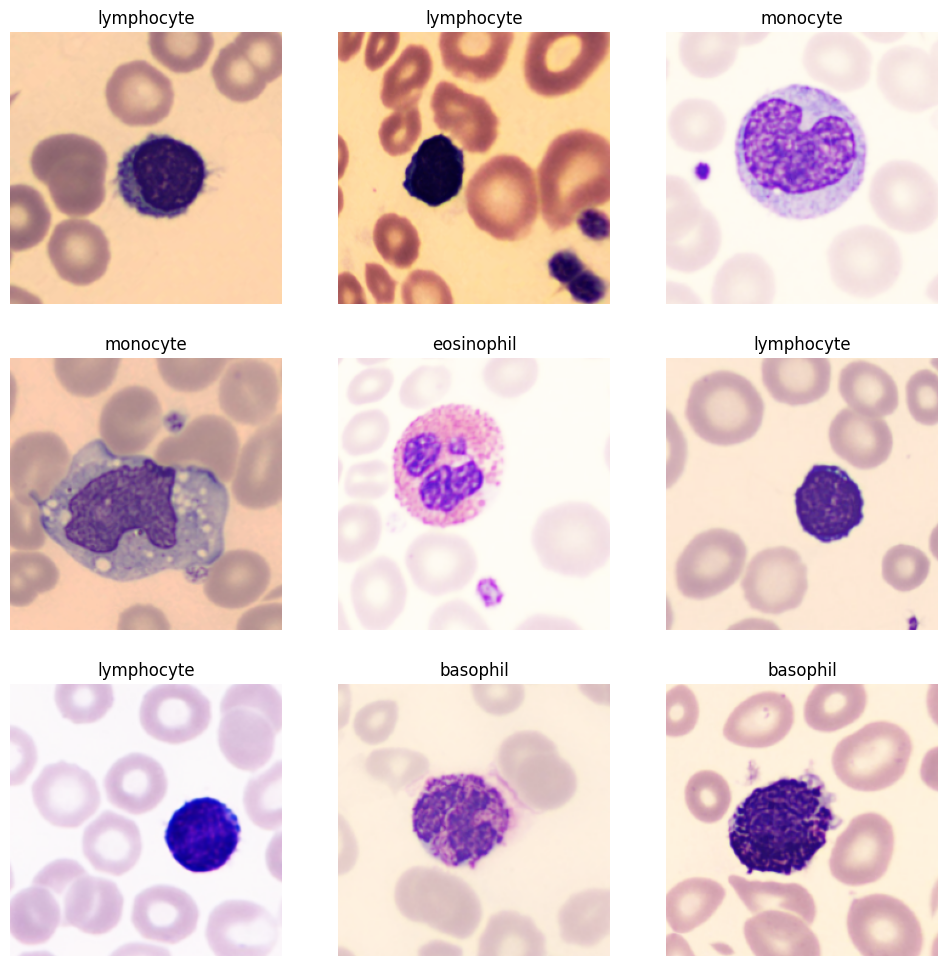

In [52]:
# Visualize a batch with augmentations
dls.show_batch(max_n=9, figsize=(12, 12))

## 5. Create Model

In [53]:
# Create learner with callbacks
learn = vision_learner(
    dls,
    ARCHITECTURE,
    metrics=[accuracy, error_rate],
    pretrained=True
)

print(f"Model Configuration:")
print(f"  Architecture: {ARCHITECTURE.__name__}")
print(f"  Number of classes: {dls.c}")
print(f"  Pretrained: True")
print(f"  Metrics: accuracy, error_rate")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mac/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 11.7MB/s]

Model Configuration:
  Architecture: resnet18
  Number of classes: 5
  Pretrained: True
  Metrics: accuracy, error_rate


## 6. Find Learning Rate

Finding optimal learning rate...



Suggested learning rate: 2.09e-03


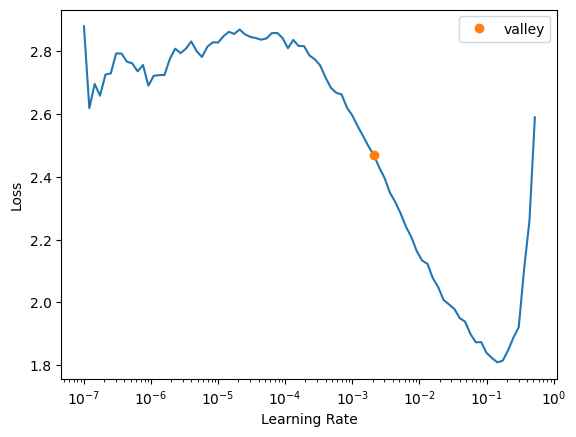

In [54]:
# Find optimal learning rate
print("Finding optimal learning rate...")
suggested_lr = learn.lr_find()

print(f"\nSuggested learning rate: {suggested_lr.valley:.2e}")

## 7. Train Model - Phase 1 (Frozen Backbone)

In [55]:
# Train with frozen backbone
# Adjust LR based on lr_find results (typically use the suggested value or slightly lower)
LR = 1e-3  # Adjust this based on the lr_find plot above

print("="*70)
print("PHASE 1: Training with Frozen Backbone")
print("="*70)
print(f"Epochs: {EPOCHS_FROZEN}")
print(f"Learning rate: {LR:.2e}")
print(f"Early stopping: patience=3 (stops if no improvement for 3 epochs)")
print("="*70)

# Add callbacks for early stopping and saving best model
cbs = [
    SaveModelCallback(monitor='valid_loss', fname='best_model_phase1'),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=3)
]

learn.fine_tune(EPOCHS_FROZEN, base_lr=LR, cbs=cbs)

PHASE 1: Training with Frozen Backbone
Epochs: 20
Learning rate: 1.00e-03
Early stopping: patience=3 (stops if no improvement for 3 epochs)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.643385,0.914947,0.725333,0.274667,00:09


Better model found at epoch 0 with valid_loss value: 0.9149467945098877.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.843398,0.427147,0.861333,0.138667,00:12
1,0.606573,0.290214,0.928000,0.072000,00:12
2,0.433523,0.227206,0.933333,0.066667,00:12
3,0.321832,0.189548,0.949333,0.050667,00:12
4,0.263399,0.109719,0.973333,0.026667,00:12
5,0.218016,0.116040,0.970667,0.029333,00:12
6,0.175945,0.134718,0.976000,0.024000,00:12
7,0.165322,0.084440,0.976000,0.024000,00:12
8,0.137414,0.087360,0.984000,0.016000,00:11
9,0.098413,0.108970,0.978667,0.021333,00:12


Better model found at epoch 0 with valid_loss value: 0.4271470010280609.
Better model found at epoch 1 with valid_loss value: 0.2902136743068695.
Better model found at epoch 2 with valid_loss value: 0.22720609605312347.
Better model found at epoch 3 with valid_loss value: 0.18954840302467346.
Better model found at epoch 4 with valid_loss value: 0.10971882194280624.
Better model found at epoch 7 with valid_loss value: 0.08443993330001831.
No improvement since epoch 7: early stopping


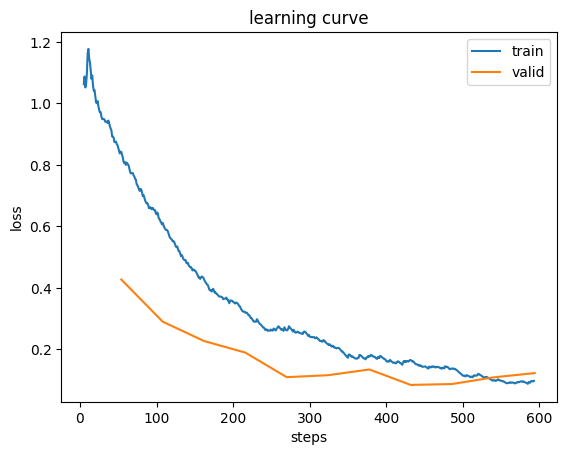

In [56]:
# Plot training history
learn.recorder.plot_loss()
plt.savefig('../outputs/figures/training_loss_phase1.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Evaluate Phase 1 Performance

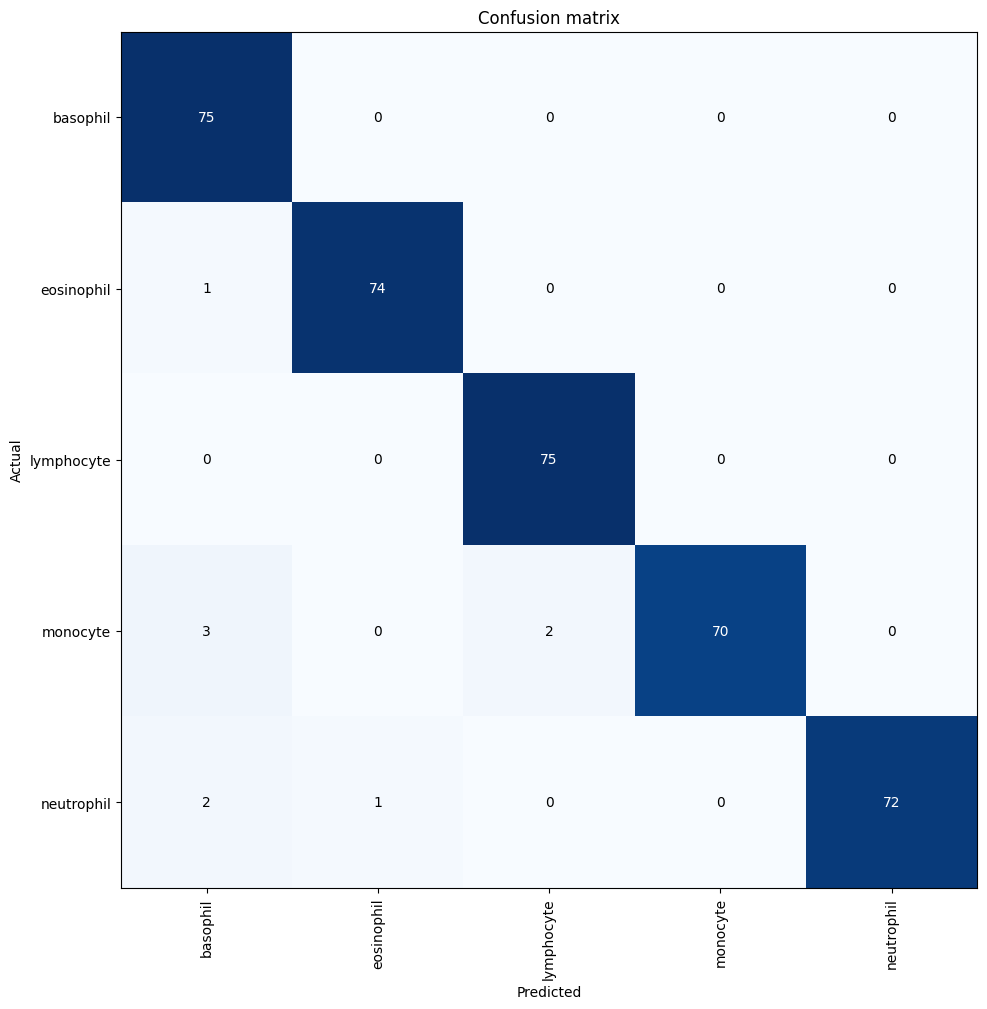

In [57]:
# Get predictions on validation set
interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix
interp.plot_confusion_matrix(figsize=(10, 10), dpi=100)
plt.savefig('../outputs/figures/confusion_matrix_phase1.png', dpi=300, bbox_inches='tight')
plt.show()

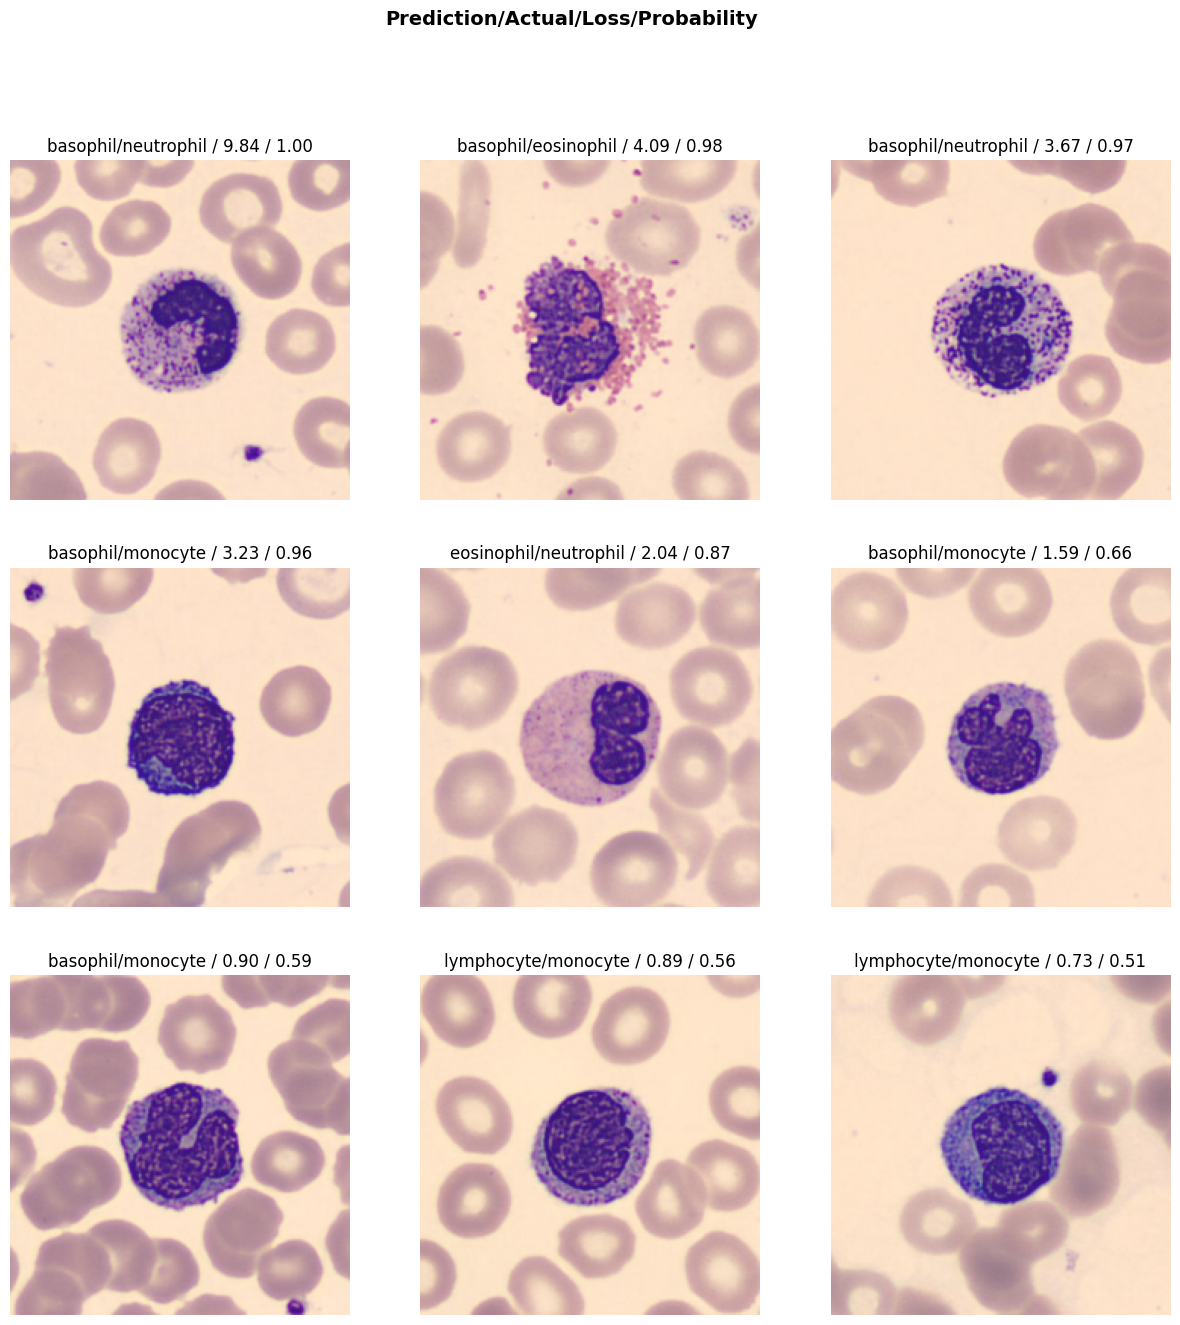

In [58]:
# Show top losses (worst predictions)
interp.plot_top_losses(9, figsize=(15, 15))

In [59]:
# Print validation metrics
val_loss, val_acc, val_err = learn.validate()

print("\n" + "="*70)
print("PHASE 1 RESULTS")
print("="*70)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Validation Error: {val_err:.4f} ({val_err*100:.2f}%)")
print("="*70)

# Store Phase 1 results
phase1_acc = val_acc


PHASE 1 RESULTS
Validation Loss: 0.0844
Validation Accuracy: 0.9760 (97.60%)
Validation Error: 0.0240 (2.40%)


## 9. Train Model - Phase 2 (Unfrozen with Fine-Tuning)

In [60]:
# Unfreeze the model
learn.unfreeze()

In [61]:
# Train with discriminative learning rates
# Use lower learning rate for unfrozen training
LR_UNFROZEN = 1e-4  # Typically 10x lower than frozen phase

print("="*70)
print("PHASE 2: Fine-tuning Unfrozen Model")
print("="*70)
print(f"Epochs: {EPOCHS_UNFROZEN}")
print(f"Learning rate: {LR_UNFROZEN:.2e}")
print(f"Early stopping: patience=5 (stops if no improvement for 5 epochs)")
print("="*70)

# Add callbacks for early stopping and saving best model
cbs = [
    SaveModelCallback(monitor='valid_loss', fname='best_model_final'),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0005, patience=5)
]

learn.fit_one_cycle(EPOCHS_UNFROZEN, lr_max=LR_UNFROZEN, cbs=cbs)

PHASE 2: Fine-tuning Unfrozen Model
Epochs: 20
Learning rate: 1.00e-04
Early stopping: patience=5 (stops if no improvement for 5 epochs)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.089000,0.101055,0.973333,0.026667,00:12
1,0.087089,0.107475,0.978667,0.021333,00:11
2,0.091724,0.131810,0.962667,0.037333,00:11
3,0.127326,0.090266,0.978667,0.021333,00:12
4,0.124432,0.055458,0.981333,0.018667,00:12
5,0.114658,0.286601,0.933333,0.066667,00:12
6,0.098267,0.066394,0.984000,0.016000,00:12
7,0.069359,0.036925,0.984000,0.016000,00:12
8,0.066368,0.079833,0.981333,0.018667,00:12
9,0.052822,0.143575,0.960000,0.040000,00:12


Better model found at epoch 0 with valid_loss value: 0.10105452686548233.
Better model found at epoch 3 with valid_loss value: 0.09026592969894409.
Better model found at epoch 4 with valid_loss value: 0.0554579459130764.
Better model found at epoch 7 with valid_loss value: 0.0369245707988739.
Better model found at epoch 12 with valid_loss value: 0.024375291541218758.
Better model found at epoch 15 with valid_loss value: 0.01427890732884407.


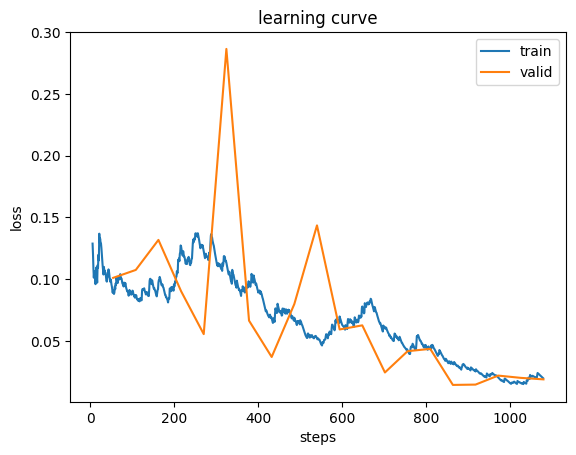

In [62]:
# Plot training history for Phase 2
learn.recorder.plot_loss()
plt.savefig('../outputs/figures/training_loss_phase2.png', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
# Optionally load the best model from Phase 2 if early stopping triggered
# This ensures we use the model with the lowest validation loss
best_model_path = learn.path/learn.model_dir/'best_model_final.pth'
if best_model_path.exists():
    print(f"Loading best model from: {best_model_path}")
    learn.load('best_model_final')
    print("✓ Best model loaded")
else:
    print("No saved model found - using current model state")

Loading best model from: models/best_model_final.pth
✓ Best model loaded


/Users/mac/miniconda3/envs/cv/lib/python3.11/site-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


## 10. Final Evaluation on Validation Set

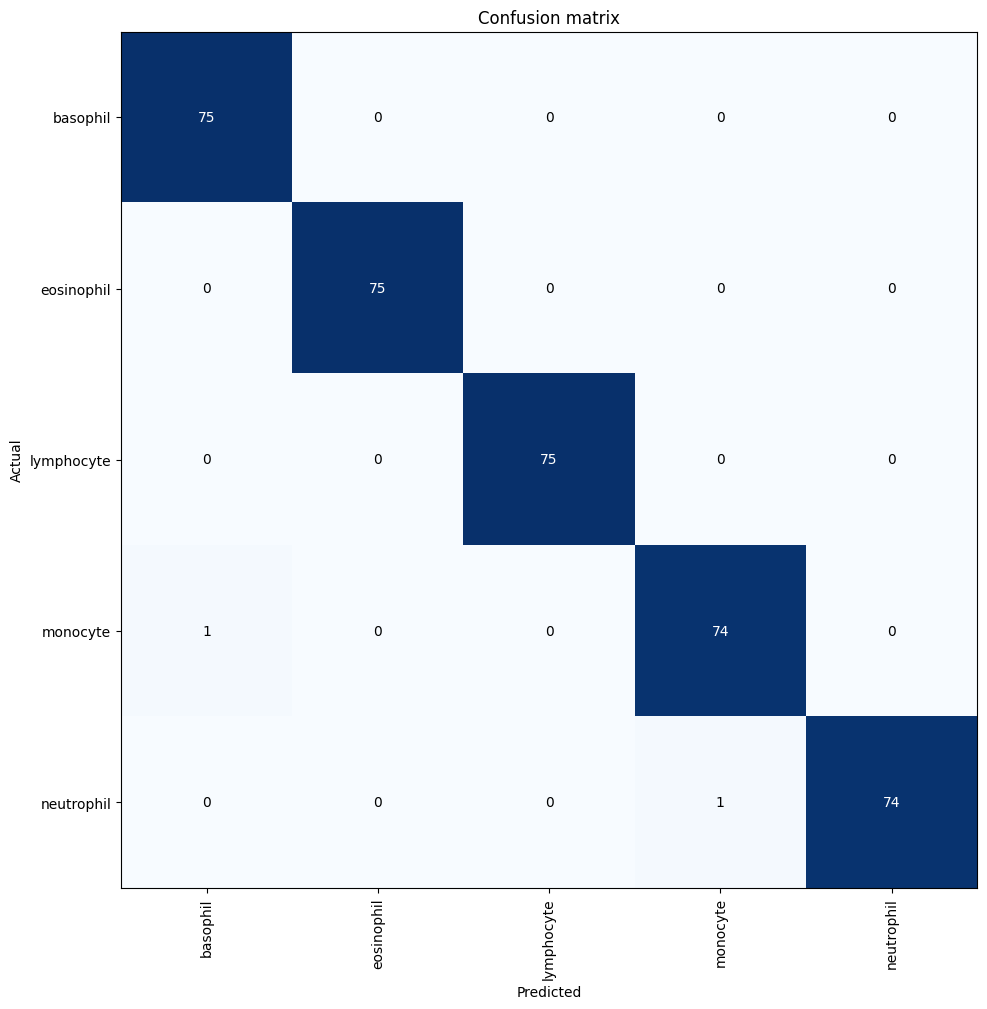

In [64]:
# Get final predictions
interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix
interp.plot_confusion_matrix(figsize=(10, 10), dpi=100)
plt.savefig('../outputs/figures/confusion_matrix_validation.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
# Most confused classes
print("Most confused classes:")
confused = interp.most_confused(min_val=2)
if confused:
    for item in confused:
        print(f"  {item[0]:12s} → {item[1]:12s} : {item[2]} times")
else:
    print("  No significant confusions!")

Most confused classes:


  No significant confusions!


In [66]:
# Final validation metrics
val_loss, val_acc, val_err = learn.validate()

print("\n" + "="*70)
print("FINAL VALIDATION RESULTS (After Phase 2)")
print("="*70)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Validation Error: {val_err:.4f} ({val_err*100:.2f}%)")
print(f"\nImprovement from Phase 1: {(val_acc - phase1_acc)*100:+.2f}%")
print("="*70)


FINAL VALIDATION RESULTS (After Phase 2)
Validation Loss: 0.0143
Validation Accuracy: 0.9947 (99.47%)
Validation Error: 0.0053 (0.53%)

Improvement from Phase 1: +1.87%


## 11. Test on External Dataset (Quick Validation)

In [67]:
# Quick test on external dataset to check generalization
external_path = Path('../Dataset and Notebook-20251115/test_second_dataset')

if external_path.exists():
    # Get all external samples
    external_files = list(external_path.glob('*/*.jpg'))
    
    print(f"Testing on {len(external_files)} external samples...\n")
    
    correct = 0
    predictions = []
    
    for img_path in external_files:
        true_label = img_path.parent.name.lower()
        img = PILImage.create(img_path)
        pred, pred_idx, probs = learn.predict(img)
        
        pred_label = str(pred).lower()
        is_correct = pred_label == true_label
        correct += is_correct
        
        predictions.append({
            'file': img_path.name,
            'true': true_label,
            'pred': pred_label,
            'confidence': probs.max().item(),
            'correct': is_correct
        })
    
    # Show sample predictions
    print("Sample predictions (first 10):")
    for p in predictions[:10]:
        status = "✓" if p['correct'] else "✗"
        print(f"{status} True: {p['true']:12s} | Pred: {p['pred']:12s} | Conf: {p['confidence']:.3f}")
    
    external_acc = correct / len(external_files)
    
    print("\n" + "="*70)
    print("EXTERNAL DATASET QUICK CHECK")
    print("="*70)
    print(f"Accuracy: {external_acc:.4f} ({external_acc*100:.2f}%)")
    print(f"Correct: {correct}/{len(external_files)}")
    
    if external_acc >= 0.92:
        print(f"\n✓ TARGET ACHIEVED: ≥92% accuracy on external dataset!")
    else:
        print(f"\n⚠ Below target: Need {(0.92 - external_acc)*100:.2f}% more for 92% target")
    
    print("="*70)
else:
    print("⚠ External dataset not found")
    external_acc = None

Testing on 9 external samples...



Sample predictions (first 10):
✓ True: monocyte     | Pred: monocyte     | Conf: 0.999
✓ True: monocyte     | Pred: monocyte     | Conf: 0.998
✓ True: monocyte     | Pred: monocyte     | Conf: 1.000
✓ True: monocyte     | Pred: monocyte     | Conf: 0.691
✓ True: monocyte     | Pred: monocyte     | Conf: 0.833
✓ True: monocyte     | Pred: monocyte     | Conf: 0.998
✓ True: monocyte     | Pred: monocyte     | Conf: 0.975
✓ True: monocyte     | Pred: monocyte     | Conf: 0.695
✓ True: monocyte     | Pred: monocyte     | Conf: 0.811

EXTERNAL DATASET QUICK CHECK
Accuracy: 1.0000 (100.00%)
Correct: 9/9

✓ TARGET ACHIEVED: ≥92% accuracy on external dataset!


## 12. Final Model Export with Verification

**IMPORTANT**: This section ensures we export the best-performing model with full verification.

In [68]:
import json
from datetime import datetime

print("="*70)
print("FINAL MODEL EXPORT")
print("="*70)

# Step 1: Explicitly verify best model is loaded
best_model_path = learn.path/learn.model_dir/'best_model_final.pth'
if best_model_path.exists():
    print("\n[1/5] Loading best model checkpoint...")
    learn.load('best_model_final')
    print("      ✓ Best model from Phase 2 loaded")
else:
    print("\n[1/5] ⚠️  WARNING: No best_model_final.pth found!")
    print("      Using current model state (may not be optimal)")

# Step 2: Re-verify validation performance
print("\n[2/5] Verifying validation performance...")
val_loss, val_acc, val_err = learn.validate()
print(f"      Validation Accuracy: {val_acc*100:.2f}%")
print(f"      Validation Loss: {val_loss:.4f}")

# Step 3: Test on external dataset RIGHT BEFORE export
print("\n[3/5] Testing on external dataset...")
external_path = Path('../Dataset and Notebook-20251115/test_second_dataset')
if external_path.exists():
    external_files = sorted(list(external_path.glob('*/*.jpg')))
    correct = 0
    
    for img_path in external_files:
        true_label = img_path.parent.name.lower()
        img = PILImage.create(img_path)
        pred = str(learn.predict(img)[0]).lower()
        if pred == true_label:
            correct += 1
    
    external_acc = correct / len(external_files)
    print(f"      External Accuracy: {external_acc*100:.2f}% ({correct}/{len(external_files)})")
else:
    external_acc = None
    print("      ⚠️  External dataset not found")

# Step 4: Export model
print("\n[4/5] Exporting model...")
model_path = '../outputs/model.pkl'
learn.export(model_path)
print(f"      ✓ Model exported to: {model_path}")

# Save metadata about this export
metadata = {
    'export_timestamp': datetime.now().isoformat(),
    'architecture': ARCHITECTURE.__name__,
    'image_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'random_seed': SEED,
    'validation_accuracy': float(val_acc),
    'validation_loss': float(val_loss),
    'external_accuracy': float(external_acc) if external_acc is not None else None,
    'phase1_epochs': EPOCHS_FROZEN,
    'phase2_epochs': EPOCHS_UNFROZEN,
    'phase1_lr': float(LR),
    'phase2_lr': float(LR_UNFROZEN),
    'classes': list(learn.dls.vocab),
    'best_model_loaded': best_model_path.exists()
}

metadata_path = '../outputs/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"      ✓ Metadata saved to: {metadata_path}")

# Step 5: Verify exported model loads correctly
print("\n[5/5] Verifying exported model...")
learn_test = load_learner(model_path)
print(f"      ✓ Model loads successfully")
print(f"      Classes: {learn_test.dls.vocab}")

# Test prediction
test_img_path = train_val_df.iloc[0]['filepath']
test_img = PILImage.create(test_img_path)
pred, pred_idx, probs = learn_test.predict(test_img)
print(f"      ✓ Test prediction works: {pred} (conf: {probs.max():.3f})")

print("\n" + "="*70)
print("✅ MODEL EXPORT COMPLETE AND VERIFIED!")
print("="*70)
print(f"\n📦 Exported Model:")
print(f"   File: {model_path}")
print(f"   Validation Acc: {val_acc*100:.2f}%")
if external_acc is not None:
    print(f"   External Acc: {external_acc*100:.2f}%")
print(f"   Timestamp: {metadata['export_timestamp']}")
print("\n✓ This model is ready for submission")
print("✓ Loads with: learn = load_learner('model.pkl')")
print("="*70)

FINAL MODEL EXPORT

[1/5] Loading best model checkpoint...
      ✓ Best model from Phase 2 loaded

[2/5] Verifying validation performance...


/Users/mac/miniconda3/envs/cv/lib/python3.11/site-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


      Validation Accuracy: 99.47%
      Validation Loss: 0.0143

[3/5] Testing on external dataset...


      External Accuracy: 100.00% (9/9)

[4/5] Exporting model...
      ✓ Model exported to: ../outputs/model.pkl
      ✓ Metadata saved to: ../outputs/model_metadata.json

[5/5] Verifying exported model...
      ✓ Model loads successfully
      Classes: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']


/Users/mac/miniconda3/envs/cv/lib/python3.11/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


      ✓ Test prediction works: neutrophil (conf: 1.000)

✅ MODEL EXPORT COMPLETE AND VERIFIED!

📦 Exported Model:
   File: ../outputs/model.pkl
   Validation Acc: 99.47%
   External Acc: 100.00%
   Timestamp: 2025-11-15T10:48:40.377633

✓ This model is ready for submission
✓ Loads with: learn = load_learner('model.pkl')


## 13. Training Summary

In [69]:
print("="*70)
print("MODEL TRAINING SUMMARY")
print("="*70)
print(f"\n📊 Model Configuration:")
print(f"  Architecture: {ARCHITECTURE.__name__}")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of classes: {dls.c}")
print(f"  Random seed: {SEED}")

print(f"\n🏋️ Training Configuration:")
print(f"  Phase 1 (Frozen): {EPOCHS_FROZEN} epochs @ LR={LR:.2e}")
print(f"  Phase 2 (Unfrozen): {EPOCHS_UNFROZEN} epochs @ LR={LR_UNFROZEN:.2e}")
print(f"  Total epochs: {EPOCHS_FROZEN + EPOCHS_UNFROZEN}")

print(f"\n📈 Final Performance:")
print(f"  Validation Accuracy: {val_acc*100:.2f}%")
print(f"  Validation Error: {val_err*100:.2f}%")
if external_acc is not None:
    print(f"  External Accuracy: {external_acc*100:.2f}%")
    print(f"  Generalization Gap: {abs(val_acc - external_acc)*100:.2f}%")

print(f"\n💾 Output Files:")
print(f"  ✓ {model_path}")
print(f"  ✓ ../outputs/figures/training_loss_phase1.png")
print(f"  ✓ ../outputs/figures/training_loss_phase2.png")
print(f"  ✓ ../outputs/figures/confusion_matrix_phase1.png")
print(f"  ✓ ../outputs/figures/confusion_matrix_validation.png")

print("\n" + "="*70)
print("✓ MODEL TRAINING COMPLETE!")
print("Next: Proceed to 03_model_evaluation.ipynb for comprehensive evaluation")
print("="*70)

MODEL TRAINING SUMMARY

📊 Model Configuration:
  Architecture: resnet18
  Image size: 224x224
  Batch size: 32
  Number of classes: 5
  Random seed: 42

🏋️ Training Configuration:
  Phase 1 (Frozen): 20 epochs @ LR=1.00e-03
  Phase 2 (Unfrozen): 20 epochs @ LR=1.00e-04
  Total epochs: 40

📈 Final Performance:
  Validation Accuracy: 99.47%
  Validation Error: 0.53%
  External Accuracy: 100.00%
  Generalization Gap: 0.53%

💾 Output Files:
  ✓ ../outputs/model.pkl
  ✓ ../outputs/figures/training_loss_phase1.png
  ✓ ../outputs/figures/training_loss_phase2.png
  ✓ ../outputs/figures/confusion_matrix_phase1.png
  ✓ ../outputs/figures/confusion_matrix_validation.png

✓ MODEL TRAINING COMPLETE!
Next: Proceed to 03_model_evaluation.ipynb for comprehensive evaluation
